# Ensemble Learning Exercise

## 1. Implementing Random Forest From Scratch (30 points)
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your model will handle **continuous input and output**. 

* Compelete the skeleton class below (you should use scikit-learn's `DecisionTreeRegressor` model that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  

* The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

* To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
 


In [4]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [5]:
from sklearn.datasets import load_boston
X,y=load_boston(return_X_y=True)

In [6]:
from sklearn.tree import DecisionTreeRegressor as dtree
from sklearn.metrics import mean_squared_error

In [7]:
class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_sz, n_features, min_leaf):
        self.trees = []
        self.n_trees, self.sample_sz, self.n_features, self.min_leaf=n_trees, sample_sz, n_features, min_leaf
        for i in range(self.n_trees):
            samples = np.random.choice([i for i in range(X.shape[0])],size=sample_sz,replace=True)
            features = np.random.choice([i for i in range(X.shape[1])],size=n_features)
            sample_2_fit = X[samples,:][:,features]
            new_tree = dtree(min_samples_leaf=self.min_leaf)
            new_tree.fit(sample_2_fit,y[samples])
            self.trees.append([new_tree,features,samples])
    def predict(self, X):
        self.predictions=[]
        for i in self.trees:
            self.predictions.append(i[0].predict(X[:,i[1]]))
        return np.vstack(self.predictions).mean(axis=0)

    def oob_mse(self):
        self.oob=0
        for tree in self.trees:
            self.oob=self.oob+mean_squared_error(tree[0].predict(X[~tree[2],:][:,tree[1]]),y[~tree[2]])
        self.oob=self.oob/len(self.trees)
        return self.oob


In [8]:
rfc = TreeEnsemble(X,y,10,100,10,20)
print("oob_mse:",rfc.oob_mse())
print("training mse:",mean_squared_error(rfc.predict(X),y))

oob_mse: 48.96323984965753
training mse: 33.55751687645386


n_trees:1, sz:50, min_leaf:1 --- oob mse: 19.97
n_trees:1, sz:300, min_leaf:5 --- oob mse: 11.455167346844293


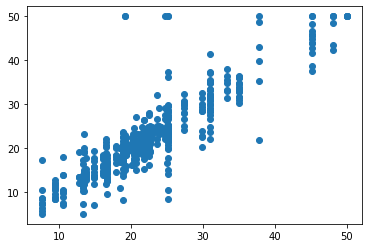

In [9]:
best_mse=np.inf
for n in [1,5,10,20,50,100]:
    for sz in [50,100,300,500]:
        for min_leaf in [1,5]:
            forest = TreeEnsemble(X, y, n, sz,n_features=6, min_leaf=min_leaf)
            mse = forest.oob_mse()
            if mse<best_mse:
                print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
                best_mse = mse
                best_forest = forest
y_hat = best_forest.predict(X)  # forest is the chosen model
plt.scatter(y_hat, y)

## 2. Implementing AdaBoost From Scratch (30 points)


*   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).
*   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` with the default parameters). 
    - Split the sample set into train and test sets.
    - Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?



In [10]:
from sklearn.metrics import accuracy_score

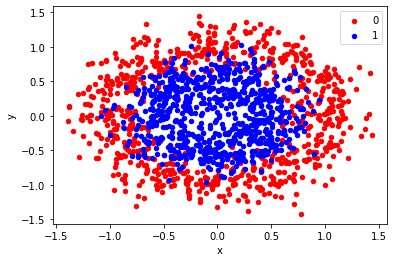

In [11]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [12]:
from sklearn.svm import SVC

In [18]:
class AdaBoost():
    def __init__(self, X, y, n_iter,learning_rate):
        self.results = []
        self.weights_list = []
        self.weights=np.ones_like(y)*1/len(y)
        self.n_iter=n_iter
        self.samples = [i for i in range(X.shape[0])]
        for i in range(self.n_iter):
            self.samples = np.random.choice(self.samples,size=len(y),replace=True,p=self.weights)
            classifier = SVC(kernel = 'rbf', random_state = 0,gamma='auto')
            clf = classifier.fit( X[self.samples,:],  y[self.samples])
            predictions = clf.predict(X[self.samples,:])
            mis_class = predictions!=y[self.samples]
            error = sum(mis_class*self.weights[self.samples])
            if error==0:
                break
            weight = learning_rate*np.log((1-error)/error)
            self.weights=self.weights[self.samples]*np.exp(-1*weight*mis_class)
            self.weights_list.append(self.weights)
            self.weights/=self.weights.sum()
            self.results.append([clf,weight])
    def predict(self, X):
        self.predictions=[]
        for i in self.results:
            self.predictions.append(i[0].predict(X)*i[1])
        return np.sign(np.vstack(self.predictions).mean(axis=0))
    

In [19]:
y_new=y.copy()
y_new[y_new==0]=-1

ab=AdaBoost(X,y_new,50,.1)

# predictions, results_list =ab.predict(X)

ValueError: too many values to unpack (expected 2)

for  1  iteration(s) accuracy score is  0.89


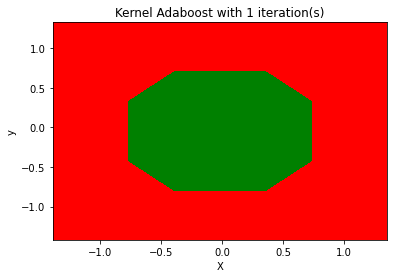

for  2  iteration(s) accuracy score is  0.8966666666666666


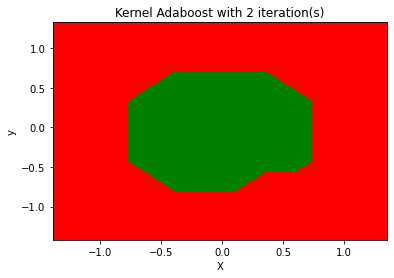

for  3  iteration(s) accuracy score is  0.89


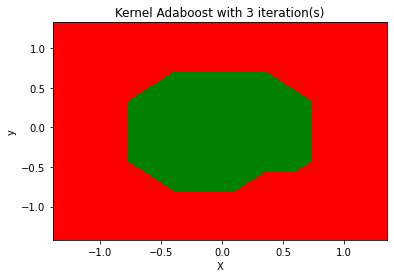

for  5  iteration(s) accuracy score is  0.8966666666666666


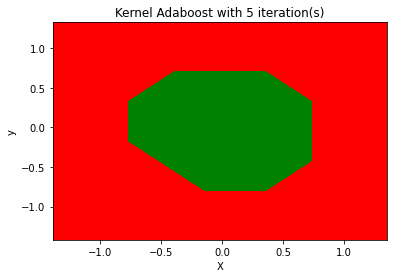

for  10  iteration(s) accuracy score is  0.86


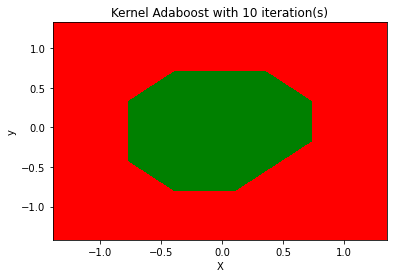

for  50  iteration(s) accuracy score is  0.8766666666666667


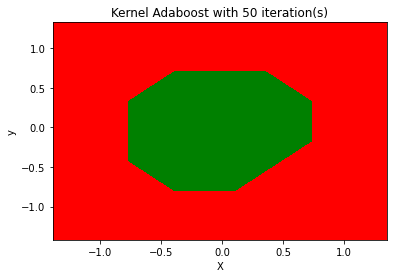

In [21]:
from sklearn.metrics import accuracy_score 
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.2, random_state=42)


accuracies_train = []
accuracies_test = []
y_new=y.copy()
y_new[y_new==0]=-1
for i in [1,2,3,5,10,50]:
    ab=AdaBoost(X_train, y_train, i, .1)
    accuracies_train.append(accuracy_score(ab.predict(X_train), y_train))
    accuracies_test.append(accuracy_score(ab.predict(X_test), y_test))
    print("for " ,i , " iteration(s) accuracy score is " , accuracy_score(ab.predict(X_test), y_test))
    X_set, y_set = X, y_new
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 0, stop = X_set[:, 0].max() + 0, step = 0.25),
                         np.arange(start = X_set[:, 1].min() - 0, stop = X_set[:, 1].max() + 0, step = 0.25))
    plt.contourf(X1, X2, ab.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                  cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
#     for i, j in enumerate(np.unique(y_set)):
#         plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c = ListedColormap(('red', 'green'))(i), label = j)
    plt.title('Kernel Adaboost with ' + str(i) + ' iteration(s)')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.show()

for  1  iteration(s) accuracy score is  0.89


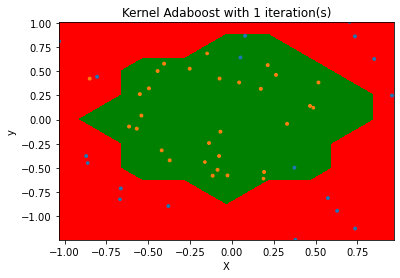

for  2  iteration(s) accuracy score is  0.89


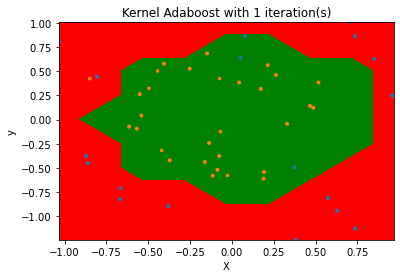

for  3  iteration(s) accuracy score is  0.89


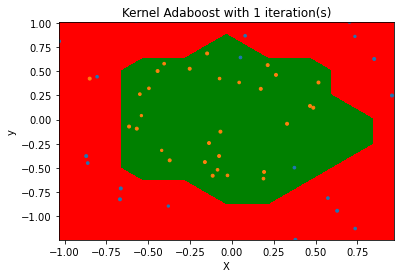

for  5  iteration(s) accuracy score is  0.8733333333333333


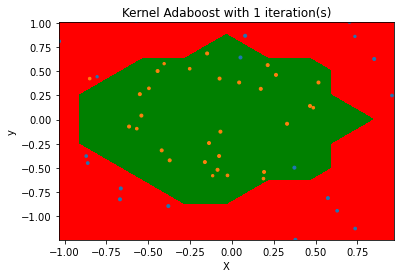

for  10  iteration(s) accuracy score is  0.8833333333333333


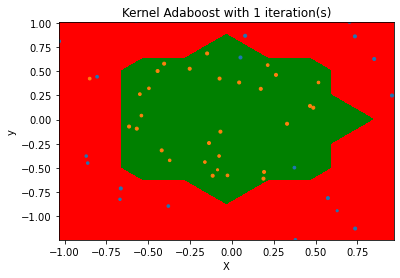

for  50  iteration(s) accuracy score is  0.8866666666666667


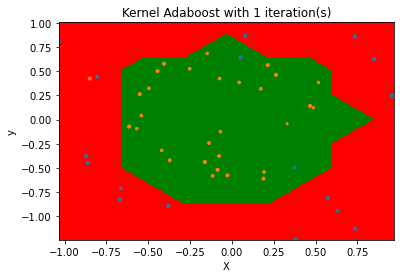

In [43]:
from sklearn.metrics import accuracy_score 
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.2, random_state=42)


accuracies_train = []
accuracies_test = []
y_new=y.copy()
y_new[y_new==0]=-1
for i in [1,2,3,5,10,50]:
    ab=AdaBoost(X_train, y_train, i, .1)
    accuracies_train.append(accuracy_score(ab.predict(X_train), y_train))
    accuracies_test.append(accuracy_score(ab.predict(X_test), y_test))
    print("for " ,i , " iteration(s) accuracy score is " , accuracy_score(ab.predict(X_test), y_test))
    X_set, y_set,weights = X[:50], y_new[:50],ab.weights[:50]
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 0, stop = X_set[:, 0].max() + 0, step = 0.25),
                         np.arange(start = X_set[:, 1].min() - 0, stop = X_set[:, 1].max() + 0, step = 0.25))
    plt.contourf(X1, X2, ab.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                  cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], label = j,s=weights[y_set == j]*10000)
#         plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], label = j,s=50)
    plt.title('Kernel Adaboost with ' + str(i) + ' iteration(s)')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.show()

In [22]:
ab.weights

array([0.00067353, 0.00071565, 0.00094774, ..., 0.00067353, 0.00094774,
       0.00094774])

In [25]:
from sklearn.metrics import accuracy_score 
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.2, random_state=42)


accuracies_train = []
accuracies_test = []
y_new=y.copy()
y_new[y_new==0]=-1


for i in [1,2,3,5,10,50]:
    ab=AdaBoost(X_train, y_train, i, .1)
    accuracies_train.append(accuracy_score(ab.predict(X_train), y_train))
    accuracies_test.append(accuracy_score(ab.predict(X_test), y_test))
    print("for " ,i , " iteration(s) accuracy score is " , accuracy_score(ab.predict(X_test), y_test))
    print(np.std(ab.weights))

for  1  iteration(s) accuracy score is  0.8833333333333333
5.019152907815351e-05
for  2  iteration(s) accuracy score is  0.8866666666666667
7.204576471960537e-05
for  3  iteration(s) accuracy score is  0.9033333333333333
7.20778756914058e-05
for  5  iteration(s) accuracy score is  0.8833333333333333
0.00010678004272124733
for  10  iteration(s) accuracy score is  0.8966666666666666
0.00012212817868805675
for  50  iteration(s) accuracy score is  0.88
0.00011282874834176078


## show the point of overfitting

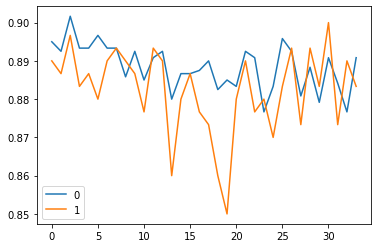

In [325]:
iters = np.unique([int(i) for i in np.logspace(0,2)])

train_error=list()
test_error = list()
for i in iters:
    booster = AdaBoost(X_train,y_train,int(i),.1)
    train_error.append(accuracy_score(booster.predict(X_train),y_train))
    test_error.append(accuracy_score(booster.predict(X_test),y_test))
df=pd.DataFrame(zip(train_error,test_error))
df.plot()

We see the model overfitting at....

## 3. Boosting Trees from Scratch (40 points)
* Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
* Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
* Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
* Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [233]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
X,y = load_boston(True)
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [147]:
from sklearn.tree import DecisionTreeRegressor as dtree


In [238]:
class l2boost():
    def __init__(self, X, y, n_iter,learning_rate):
        self.results = []
        self.resid=y
        self.n_iter=n_iter
        self.learning_rate=learning_rate
        self.first_clf=dtree(max_depth=1)
        self.first_clf.fit(X,y)
        self.predictions = self.first_clf.predict(X)
        self.resid = y-self.predictions
        for i in range(self.n_iter):
            classifier = dtree(max_depth=1)
            clf = classifier.fit( X,  self.resid)
            self.predictions = self.predictions+learning_rate*clf.predict(X)
            self.results.append([clf])
            self.resid = y-self.predictions
#             print(np.square(self.resid).mean())
    def predict(self, X):
        self.r_predictions=[]
        for i in self.results:
            self.r_predictions.append(i[0].predict(X))
        return self.first_clf.predict(X)+self.learning_rate*np.vstack(self.r_predictions).sum(axis=0)


In [225]:
from sklearn.metrics import mean_squared_error as mse

## show the point of overfitting

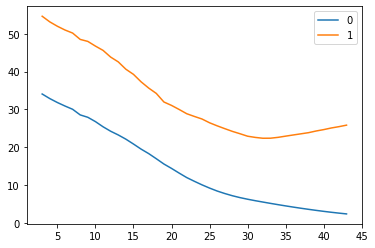

In [286]:
iters = np.unique([int(i) for i in np.logspace(0,3.5)])

train_error=list()
test_error = list()
for i in iters:
    booster = l2boost(X_train,y_train,int(i),.1)
    train_error.append(mse(booster.predict(X_train),y_train))
    test_error.append(mse(booster.predict(X_test),y_test))
df=pd.DataFrame(zip(train_error,test_error))
df[3:].plot()

## Find optimal hyperparameters

In [259]:
iters = np.unique([int(i) for i in np.logspace(0,3)])
lrs = np.unique([np.round(i,2) for i in np.logspace(-3,-.5)])

train_error=dict()
test_error = dict()
for i in iters:
    train_error[i]=dict()
    test_error[i]=dict()
    for j in lrs:
        booster = l2boost(X_train,y_train,int(i),j)
        train_error[i][j]=mse(booster.predict(X_train),y_train)
        test_error[i][j]=mse(booster.predict(X_test),y_test)

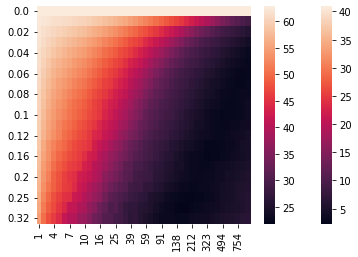

In [283]:
import seaborn as sns
sns.heatmap(pd.DataFrame(train_error))

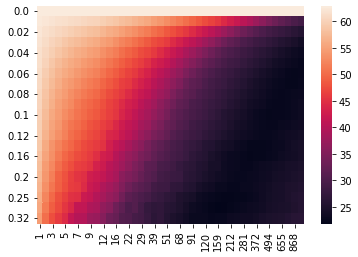

In [284]:
sns.heatmap(pd.DataFrame(test_error))

In [282]:
test=pd.DataFrame(test_error)
n_iter = test.min().idxmin()
lr = test[n_iter].idxmin()
lr,n_iter

(0.28, 159)

## Max_depth for decision tree regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor as 

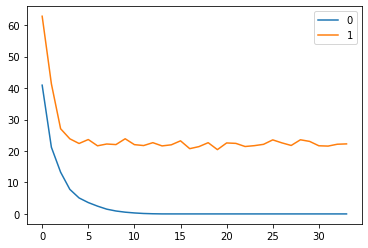

In [289]:
iters = np.unique([int(i) for i in np.logspace(0,2)])

train_error=list()
test_error = list()
for i in iters:
    dtr = dtree(max_depth=i)
    dtr.fit(X_train,y_train)
    train_error.append(mse(dtr.predict(X_train),y_train))
    test_error.append(mse(dtr.predict(X_test),y_test))
df=pd.DataFrame(zip(train_error,test_error))
df.plot()

In [292]:
dtr = dtree(max_depth =5)
dtr.fit(X_train,y_train)
mse(dtr.predict(X_test),y_test)

23.482866322656015

In [293]:
booster = l2boost(X_train,y_train,n_iter,lr)
mse(booster.predict(X_test),y_test)

21.805271245533614

***WE HAVE A WINNER!***